In [1]:
# Importing the necessary libraries

import pandas as pd
import numpy as np
from nltk.corpus import stopwords
# from nltk import ngrams
from nltk import word_tokenize
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from nltk.stem import PorterStemmer 
from sklearn import metrics
import matplotlib.pyplot as plt


In [2]:
# Reading the data set
df = pd.read_csv('ISEAR.csv',header=None)
print (df.shape)

(7516, 3)


# Emotion Detection From Tweets

In [3]:
#Remove 3 Classes:
df2 = df[df.iloc[ : , 0 ] != 'disgust']
df2 = df2[df2.iloc[ : , 0 ] != 'guilt']
df2 = df2[df2.iloc[ : , 0 ] != 'shame']
print (df2.shape)


(4329, 3)


In [4]:
# Removing the null values from the data set and specifying the column names
col = [0,1]
new_df = df[col]
new_df = new_df[pd.notnull(df[1])]
new_df.columns = ['Emotion','Text']
print(new_df.shape)
new_df = new_df[new_df.Emotion != 'disgust']
new_df = new_df[new_df.Emotion != 'guilt']

new_df = new_df[new_df.Emotion != 'shame']

print(new_df.shape)

new_df.head()
new_df.to_csv('temp.csv')

(7516, 2)
(4329, 2)


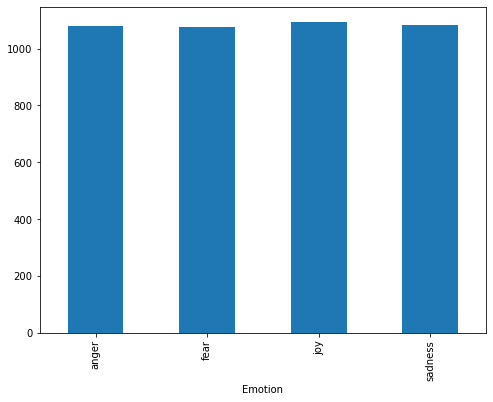

Emotion
anger      1079
fear       1076
joy        1092
sadness    1082
dtype: int64


In [5]:
#To get the plot of the emotion distribution in data
fig = plt.figure(figsize=(8,6))
new_df.groupby('Emotion').Text.count().plot.bar(ylim=0)
plt.show()
# new_df.Emotion.value_counts()
print(new_df.groupby('Emotion').size())

In [6]:
# Preprocessing the data set
# Performing Tokenization,removing new lines,punctuations
def getTokenizedList(input_df):
    tokenizedList=[]
    for i in range(0,len(input_df)):
        curText=input_df[1].iloc[i]
        curText=curText.replace('\n','')
        curTokenized=word_tokenize(curText)
        tokenizedList.append(curTokenized)
    tokenziedListWithoutPunct=[] 
    punctList=list(string.punctuation)
    for i in range(0,len(tokenizedList)):
        curList=tokenizedList[i]
        newList=[] #list without stopwords
        for word in curList:
            if (word.lower() not in punctList):
                newList.append(word.lower())
        tokenziedListWithoutPunct.append(newList)

    #Stemming
    mystemmer=PorterStemmer()
    tokenziedStemmed=[]
    for i in range(0,len(tokenziedListWithoutPunct)):
        curList=tokenziedListWithoutPunct[i]
        newList=[] 
        for word in curList:
            newList.append(mystemmer.stem(word))
        tokenziedStemmed.append(newList)
    return tokenziedStemmed

In [7]:
# Preprocessing the sentence which we input to predict the emotion
def transformSentence(sent):
    s = []
    sent=sent.replace('\n','')
    sentTokenized=word_tokenize(sent)
    s.append(sentTokenized)
    sWithoutPunct = []
    punctList = list(string.punctuation)
    curSentList = s[0]
    newSentList = []
    for word in curSentList:
        if (word.lower() not in punctList):
            newSentList.append(word.lower())
    sWithoutPunct.append(newSentList)
    mystemmer = PorterStemmer()
    tokenziedStemmed = []
    for i in range(0,len(sWithoutPunct)):
        curList=sWithoutPunct[i]
        newList=[]
        for word in curList:
            newList.append(mystemmer.stem(word))
        tokenziedStemmed.append(newList)
    return tokenziedStemmed

In [8]:
new_df['Text']=getTokenizedList(df2)

In [9]:
#splitting the data set into Training and Testing sets
X_train, X_test, Y_train, Y_test=train_test_split(new_df['Text'],new_df['Emotion'], test_size=.2,random_state=1)

In [10]:
#Function to pass the list to the Tfidf vectorizer
def returnPhrase(inputList):
    return inputList

## Naive Bayes

In [11]:
#Extracting features for Naive Bayes
myVectorizer=TfidfVectorizer(analyzer='word',tokenizer=returnPhrase,preprocessor=returnPhrase,token_pattern=None,ngram_range=(1,3))
myVectorizer.fit(X_train)
transformedTrain=myVectorizer.transform(X_train).toarray()
transformedTest=myVectorizer.transform(X_test).toarray()

In [12]:
# Training MultinomialNB and evaluating the performance
curAlpha=0.33 #smoothing factor in NB
NBClassifier=MultinomialNB(alpha=curAlpha)
NBClassifier.fit(transformedTrain,Y_train)
myPredTest=NBClassifier.predict(transformedTest)
NbScore = NBClassifier.score(transformedTest,Y_test)
print('Naive Bayes Model Accuracy: ',NbScore)

Naive Bayes Model Accuracy:  0.7517321016166282


In [13]:
# Finding Precision,recall,and f1-score for Naive Bayes

print('Metrics Classification Report : Naive Bayes')
print(metrics.classification_report(Y_test, myPredTest))
report = metrics.classification_report(Y_test, myPredTest, output_dict=True)
df = pd.DataFrame(report).transpose()
print (report)
df.to_csv("NBClassificationReport.csv")
print(metrics.classification_report(Y_test, myPredTest, digits=2))

Metrics Classification Report : Naive Bayes
              precision    recall  f1-score   support

       anger       0.71      0.74      0.73       208
        fear       0.83      0.78      0.80       232
         joy       0.83      0.78      0.81       221
     sadness       0.64      0.71      0.67       205

    accuracy                           0.75       866
   macro avg       0.75      0.75      0.75       866
weighted avg       0.76      0.75      0.75       866

{'anger': {'precision': 0.7149532710280374, 'recall': 0.7355769230769231, 'f1-score': 0.7251184834123223, 'support': 208}, 'fear': {'precision': 0.8256880733944955, 'recall': 0.7758620689655172, 'f1-score': 0.8, 'support': 232}, 'joy': {'precision': 0.8317307692307693, 'recall': 0.7828054298642534, 'f1-score': 0.8065268065268065, 'support': 221}, 'sadness': {'precision': 0.6415929203539823, 'recall': 0.7073170731707317, 'f1-score': 0.6728538283062645, 'support': 205}, 'accuracy': 0.7517321016166282, 'macro avg': {'p

## SVM

In [14]:
#Extracting the features for SVM
myVectorizer=TfidfVectorizer(analyzer='word',tokenizer=returnPhrase,preprocessor=returnPhrase,token_pattern=None,ngram_range=(1,3))
myVectorizer.fit(X_train)
transformedTrain=myVectorizer.transform(X_train).toarray()
transformedTest=myVectorizer.transform(X_test).toarray()

In [15]:
# Training the SVM Model and Evaluating the performance
curC=2   #cost factor in SVM
SVMClassifier=svm.LinearSVC(C=curC)
SVMClassifier.fit(transformedTrain,Y_train)
myPredTest=SVMClassifier.predict(transformedTest)
SVMScore = SVMClassifier.score(transformedTest,Y_test)
print('SVM Model Accuracy: ',SVMScore)

SVM Model Accuracy:  0.7725173210161663


In [16]:
#Finding the precision,recall and f1-score for each emotion - SVM
print('Metrics Classification Report : SVM')
report = metrics.classification_report(Y_test, myPredTest, output_dict=True)
df = pd.DataFrame(report).transpose()
print (report)
df.to_csv("SvmClassificationReport.csv")
print(metrics.classification_report(Y_test, myPredTest, digits=2))

Metrics Classification Report : SVM
{'anger': {'precision': 0.7242990654205608, 'recall': 0.7451923076923077, 'f1-score': 0.7345971563981043, 'support': 208}, 'fear': {'precision': 0.8088888888888889, 'recall': 0.7844827586206896, 'f1-score': 0.7964989059080962, 'support': 232}, 'joy': {'precision': 0.8318181818181818, 'recall': 0.8280542986425339, 'f1-score': 0.8299319727891156, 'support': 221}, 'sadness': {'precision': 0.7198067632850241, 'recall': 0.7268292682926829, 'f1-score': 0.7233009708737865, 'support': 205}, 'accuracy': 0.7725173210161663, 'macro avg': {'precision': 0.7712032248531638, 'recall': 0.7711396583120536, 'f1-score': 0.7710822514922757, 'support': 866}, 'weighted avg': {'precision': 0.7733356033313475, 'recall': 0.7725173210161663, 'f1-score': 0.7728355885877654, 'support': 866}}
              precision    recall  f1-score   support

       anger       0.72      0.75      0.73       208
        fear       0.81      0.78      0.80       232
         joy       0.83   

In [17]:
#To predict the emotion of a sentence using Naive Bayes
def predictSentNB(sent):
    sentPred = NBClassifier.predict(myVectorizer.transform(transformSentence(sent)).toarray())
    return sentPred
#To predict the emotion of a sentence using SVM
def predictSentSVM(sent):
    sentPred = SVMClassifier.predict(myVectorizer.transform(transformSentence(sent)).toarray())
    return sentPred
#To test the models on your own sentecnce, please uncomment the following code:
# #Input sentence 
# sent = "I want to kill and destroy you"
# #Printing the predicted emotion
# print("Navie bayes prediction")
# print(predictSentNB(sent))
# print("SVM prediction")
# print(predictSentSVM(sent))

## Confuision Matrix

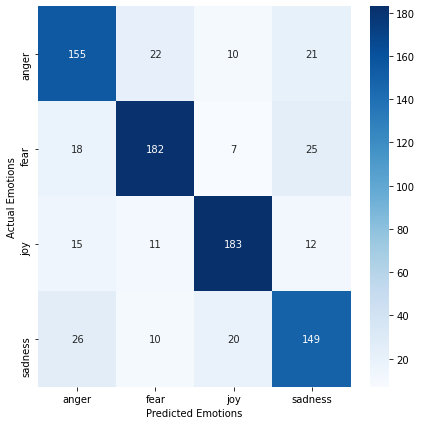

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
labels = ['anger','fear','joy','sadness']
cm = confusion_matrix(Y_test, myPredTest,labels)
#print(cm)
fig, ax = plt.subplots(figsize=(7,7))
sns.heatmap(cm, annot=True,fmt='d',
            xticklabels=labels, yticklabels=labels,cmap='Blues')
plt.ylabel('Actual Emotions')
plt.xlabel('Predicted Emotions')
plt.show()

# Predict Bibi Netanyahu Tweets Emotions

## Divide by dates:

In [19]:
dfEn = pd.read_csv('BBTweets.csv')
enTweetsList = dfEn['tweet'].tolist()
data = []
for sent in enTweetsList:
    pred = predictSentNB(sent)
    data.append((sent,pred[0]))
predDf = pd.DataFrame(data, columns = ['text','sentiment'])
predDf['date'] = dfEn['date']
predDf['date'] = pd.to_datetime(predDf['date'])
predDf = predDf.set_index(predDf['date'])
predDf = predDf.sort_index()
print('dfhe Dataset:',predDf.shape)

Seger1 = predDf['2020-01-27':'2020-04-19'] #  קמםיין בחירות שלוש +התפרצות קורונה בישראל + סגר ראשון
exitSeger1  = predDf['2020-04-19':'2020-10-14'] #סגרים 1-2 + הסכם שלום
exitSeger2  = predDf['2020-10-14':'2021-02-01'] # סגר שלישי + חיסונים
electionsCampign  = predDf['2021-02-01':'2021-03-23'] 


Seger1 = Seger1.drop(['date'], axis=1)
exitSeger1 = exitSeger1.drop(['date'], axis=1)
exitSeger2 = exitSeger2.drop(['date'], axis=1)
electionsCampign = electionsCampign.drop(['date'], axis=1)

dfhe Dataset: (2300, 3)


Seger1 Dataset: (395, 2)
<class 'matplotlib.axes._subplots.AxesSubplot'>
AxesSubplot(0.125,0.125;0.775x0.755)


[Text(0, 0, 'anger'),
 Text(0, 0, 'fear'),
 Text(0, 0, 'joy'),
 Text(0, 0, 'sadness')]

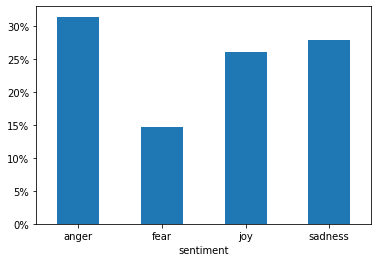

In [50]:
print('Seger1 Dataset:',Seger1.shape)
import matplotlib.ticker as mtick

tempax = pd.DataFrame(data, columns = ['text','sentiment'])
ax = Seger1 .groupby('sentiment').count().apply(lambda g: g * 100 / g.sum()).plot(kind='bar',legend=False)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
ax.set_xticklabels(['anger','fear','joy','sadness'], rotation=0)

exitSeger1 Dataset: (761, 2)


[Text(0, 0, 'anger'),
 Text(0, 0, 'fear'),
 Text(0, 0, 'joy'),
 Text(0, 0, 'sadness')]

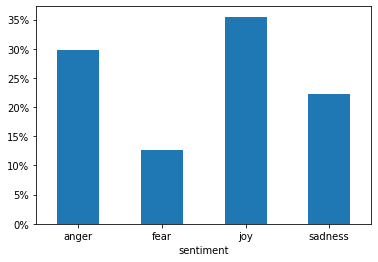

In [51]:
print('exitSeger1 Dataset:',exitSeger1.shape)

tempax = pd.DataFrame(data, columns = ['text','sentiment'])
ax = exitSeger1.groupby('sentiment').count().apply(lambda g: g * 100 / g.sum()).plot(kind='bar',legend=False)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
ax.set_xticklabels(['anger','fear','joy','sadness'], rotation=0)

exitSeger2  Dataset: (568, 2)


[Text(0, 0, 'anger'),
 Text(0, 0, 'fear'),
 Text(0, 0, 'joy'),
 Text(0, 0, 'sadness')]

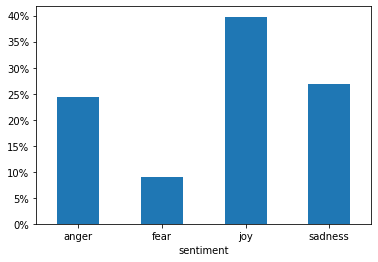

In [52]:
print('exitSeger2  Dataset:',exitSeger2 .shape)

tempax = pd.DataFrame(data, columns = ['text','sentiment'])
ax = exitSeger2.groupby('sentiment').count().apply(lambda g: g * 100 / g.sum()).plot(kind='bar',legend=False)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
ax.set_xticklabels(['anger','fear','joy','sadness'], rotation=0)

electionsCampign Dataset: (391, 2)


[Text(0, 0, 'anger'),
 Text(0, 0, 'fear'),
 Text(0, 0, 'joy'),
 Text(0, 0, 'sadness')]

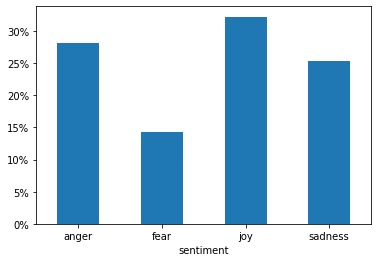

In [53]:
print('electionsCampign Dataset:',electionsCampign.shape)

tempax = pd.DataFrame(data, columns = ['text','sentiment'])
ax = electionsCampign.groupby('sentiment').count().apply(lambda g: g * 100 / g.sum()).plot(kind='bar',legend=False)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
ax.set_xticklabels(['anger','fear','joy','sadness'], rotation=0)

# Binyamin Netanyahu Tweets Analysis

In [ ]:

from bidi.algorithm import get_display
#imports:
from google_trans_new import google_translator  # iw, he
import csv
from textblob import TextBlob
from textblob import Word
from PIL import Image
from nltk.stem import PorterStemmer
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
import nltk
import preprocessor as p
import sparknlp
import pyspark
# utilities
import re
import pickle
#imports:
from google_trans_new import google_translator  # iw, he
import csv
from textblob import TextBlob
from textblob import Word
from PIL import Image
from nltk.stem import PorterStemmer
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
import nltk
import preprocessor as p

# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# nltk
from nltk.stem import WordNetLemmatizer

# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
def TranslateTweets():
    df = pd.read_csv("BibiHe2.csv")
    df.head()
    translator = google_translator()
    df["tweet"] = df["tweet"].map(lambda x: translator.translate(x, lang_src='he', lang_tgt='en'))
    df.to_csv("englishBB.csv")


def lemmatizer(text):
    text = [wn.lemmatize(word) for word in text]
    return text

def getStopWords():
    print(stopwords)
    return ['את','אתה','אנחנו','אתן','אתם','הם','הן','היא','הוא','שלי','שלו','שלך','שלה','ממשלת','בערי','אזרחי','שלנו','שלכם','שלכן','שלהם','שלהן','לי','peace','a','in','with','לו','לה','לנו'
            ,'לכם','לכן','להם','להן','אותה','אותו','זה','זאת','אלה','אלו','תחת','מתחת','מעל','בין','עם','עד','נגר','על','אל','מול',
            'של','אצל','כמו','אחר','אותו','בלי','לפני','אחרי','מאחורי','עלי','עליו','עליה','עליך','עלינו','עליכם','לעיכן','עליהם','עליהן',
            'כל','כולם','כולן','כך', 'ככה','כזה','זה','זות','אותי','אותה','אותם','אותך','אותו','אותן','אותנו','ואת','את','אתכם','אתכן',
            'איתי','איתו','איתך','איתה','איתם','איתן','איתנו','and','for','Iran', 'I','gtgt','to','have','that','is','israel','איתכם','איתכן','יהיה','תהיה','היתי','היתה','היה','להיות','עצמי','עצמו','עצמה','עצמם','עצמן','עצמנו','עצמהם',
            'עצמהן','מי','מה','איפה','היכן','במקום שבו','אם','לאן','למקום שבו','מקום בו','איזה','מהיכן','איך','כיצד', 'באיזו מידה','מתי','בשעה ש','כאשר',
            'כש','למרות','לפני','אחרי','מאיזו סיבה','הסיבה שבגללה','למה','מדוע','לאיזו תכלית','כי','יש','אין','אך','מנין','מאין','מאיפה',
            'יכל','יכלה','יכלו','יכול','יכולה','יכולים','Israel','יכולות','יוכלו','יוכל','מסוגל','לא','רק','אולי','אין','לאו','אי','כלל',
            'נגד','אם','עם','אל','אלה','אלו', 'אף','על','מעל','מתחת','מצד','בשביל','לבין','באמצע','בתוך','דרך','מבעד','באמצעות','למעלה',
            'למטה','מחוץ','מן','לעבר','מכאן','כאן', 'הנה','הרי','פה','שם', 'אך','ברם','שוב','אבל','מבלי','בלי', 'מלבד','רק','בגלל',
            'מכיוון','עד','אשר','ואילו','למרות','אס','כמו','כפי','אז','אחרי','כן','לכן','לפיכך','מאד','עז','מעט','מעטים','במידה',
            'שוב','יותר','מדי', 'גם','-','כן','נו','אחר','אחרת','אחרים','אחרות','אשר','או','כדי','עוד','לכל','בכל','the','of','2','הזה','50']

In [ ]:
def WordCloudCreator(Words_Freq_Dict): #Create Wordcloud from dictionary.
    from PIL import Image
    newDict = {}
    mask = np.array(Image.open('bb.JPG'))
    
    #Manual Lemamtizion:
#     Words_Freq_Dict = MergeSameWords(Words_Freq_Dict)
    
    #Change words direction for handle hebrew issues:
    for key in Words_Freq_Dict:
        new_key = get_display(key)
        newDict[new_key] = Words_Freq_Dict[key]
    
    wordcloud = WordCloud(background_color="white",mask=mask, max_words=75, font_path='FreeSansBold.ttf',contour_width=3, contour_color='black').generate_from_frequencies(
        frequencies=newDict)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
#     plt.title("BB Tweets")
    plt.show()


def CreateWordDict(df): #Create Counting Words Dictiaonary from the data table (Words<->Freq)
    Dict = {}
    for index, row in df.iterrows():   
        for word in row['tweet'].split():
            if (word in Dict):
                Dict[word] += 1
            else:
                Dict[word] = 1
#     Dict = MergeSameWords(Dict)
    return Dict
def MergeSameWords(Dict):
    newDict = {}
    for key in Dict.keys():
        print(newDict)
        print ("*****")
        flag = 0 
        a = 'ב' + key
        b = 'ו' + key
        c = 'מ' + key
        d = 'ה' + key
        e = 'שה' + key
        f = 'כשה' + key
        if ((a and b and c and d and e and f) not in Dict.keys()):
            newDict[key] = Dict[key]
        else: 
            if (a in Dict.keys()):
                newDict[key] += Dict[a]
            if (b in Dict.keys()):
                newDict[key] += Dict[b]
            if (c in Dict.keys()):
                newDict[key] += Dict[c]
            if (d in Dict.keys()):
                newDict[key] += Dict[d]
            if (e in Dict.keys()):
                newDict[key] += Dict[e]
            if (f in Dict.keys()):
                newDict[key] += Dict[f]
    
    return newDict



In [ ]:
# dfHe = pd.read_csv('BibiHe2.csv')
# dfHe = hebrewPreProccess(dfHe)
# dfHe = dfHe[dfHe.tweet != '']
# dfHe.to_csv('dfHe.csv')
# dfHe.head()

In [ ]:
# For get all BIBI NETANYAHU tweeets into csv file:
    # Open terminal and write: twint -u netanyahu -o BibiHe2.csv --csv
    

dfHe = pd.read_csv('BibiHe2.csv')


def WordCloudCreator(Words_Freq_Dict): #Create Wordcloud from dictionary.
    from PIL import Image
    newDict = {}
    mask = np.array(Image.open('bb.jpg'))
    
    #Manual Lemamtizion:
#     Words_Freq_Dict = MergeSameWords(Words_Freq_Dict)
    
    #Change words direction for handle hebrew issues:
    for key in Words_Freq_Dict:
        new_key = get_display(key)
        newDict[new_key] = Words_Freq_Dict[key]
    
    wordcloud = WordCloud(background_color="white",mask=mask, max_words=75, font_path='FreeSansBold.ttf',contour_width=3, contour_color='black').generate_from_frequencies(
        frequencies=newDict)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
#     plt.title('Bibi Tweets')
    plt.show()


def CreateWordDict(df): #Create Counting Words Dictiaonary from the data table (Words<->Freq)
    Dict = {}
    for index, row in df.iterrows():   
        for word in row['tweet'].split():
            if (word in Dict):
                Dict[word] += 1
            else:
                Dict[word] = 1
    Dict = MergeSameWords(Dict)
    return Dict
def MergeSameWords(Dict):
    

    return Dict

WordDictTemp = CreateWordDict(dfHe)
def getStopWords():
    print(stopwords)
    return ['את','אתה','אנחנו','אתן','אתם','הם','הן','היא','הוא','שלי','שלו','שלך','שלה','ממשלת','בערי','אזרחי','שלנו','שלכם','שלכן','שלהם','ממשלה','שלהן','לי','peace','a','in','with','לו','לה','לנו'
            ,'לכם','לכן','להם','להן','אותה','אותו','זה','זאת','אלה','אלו','תחת','מתחת','מעל','בין','עם','עד','נגר','על','ישראל','אל','מול',
            'של','אצל','כמו','אחר','אותו','בלי','לפני','אחרי','מאחורי','עלי','עליו','עליה','עליך','עלינו','עליכם','לעיכן','עליהם','עליהן',
            'כל','כולם','כולן','כך', 'ככה','כזה','זה','זות','אותי','אותה','אותם','אותך','אותו','אותן','מאוד', 'יום', 'שבת', 'אנו','אותנו','ואת','חי','את','אתכם','אתכן',
            'איתי','איתו','איתך','איתה','איתם','איתן','איתנו','and','for','Iran', 'I','gtgt','to','have','that','is','israel','איתכם','איתכן','יהיה','תהיה','היתי','היתה','היה','להיות','עצמי','עצמו','עצמה','עצמם','עצמן','עצמנו','עצמהם',
            'עצמהן','מי','מה','איפה','היכן','במקום שבו','אם','לאן','למקום שבו','מקום בו','איזה','מהיכן','איך','לחיים','כיצד', 'באיזו מידה','מתי','בשעה ש','כאשר',
            'כש','למרות','לפני','אחרי','מאיזו סיבה','הסיבה שבגללה','למה','מדוע','לאיזו תכלית','כי','יש','שידור','אין','אך','מנין','מאין','מאיפה',
            'יכל','יכלה','יכלו','יכול','יכולה','יכולים','Israel','יכולות','יוכלו','יוכל','מסוגל','לא','רק','אולי','אין','לאו','אי','כלל',
            'נגד','אם','עם','אל','אלה','אלו', 'אף','על','מעל','מתחת','מצד','בשביל','לבין','באמצע','בתוך','דרך','מבעד','גנץgtgt','באמצעות','למעלה',
            'למטה','מחוץ','מן','לעבר','מכאן','כאן', 'הנה','הרי','פה','שם', 'אך','ברם','שוב','אבל','מבלי','השר', 'זל', 'שמח','בלי','ליכוד', 'מלבד','רק','בגלל',
            'מכיוון','עד','אשר','ואילו','למרות','אס','כמו','כפי','אז','אחרי','כן','לכן','לפיכך','מאד','עז','גדול','יקים','ולא','מעט','מעטים','במידה',
            'שוב','יותר','מדי', 'גם','-','כן','נו','אחר','אחרת','אחרים','אחרות''וימנע','היום','וממשלה','ראש','לישראל','לבן','ואנחנו','תודה','המדינה','שלא','למען','משרד','ועל', 'חג', 'מדינת','טוב', 'גאה', 'שני', 'שימרו', 'תלוי', 'קורה', 'זו', 'לך','לגנץ','עושים','בבית','בכם','עצמכם',''
            ,'אשר','או','כדי','עוד','לכל','בכל','the','of','2','הזה','50','לליכוד','הליכוד','וימנע']

def hebrewPreProccess(dfHe):
    #Delete Unneccery columns
    dfHe = dfHe.drop(dfHe.columns[[0, 1, 2,5,6,7,8,9,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35]], axis=1)
    #Remove punctuation
    dfHe['tweet'] = dfHe['tweet'].str.replace('[^\w\s]','')
    #Remove English words
    dfHe['tweet'] = dfHe['tweet'].apply(lambda x: " ".join(x for x in x.split() if not re.match(r'[a-zA-Z]+', x, re.I)))
    #Remove Numbers
    dfHe['tweet'] = dfHe['tweet'].apply(lambda x: " ".join(x for x in x.split() if not re.match(r'[^[a-zA-z]+[-+]?[0-9]+[a-zA-Z]+$', x, re.I)))
    #Remove Hebrew StopWords:
    stopwords = getStopWords()
    dfHe['tweet'] = dfHe['tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in stopwords))
    return (dfHe)

dfHe = hebrewPreProccess(dfHe)
dfHe = dfHe[dfHe.tweet != '']
dfHe['date'] = pd.to_datetime(dfHe['date'])
dfHe = dfHe.set_index(dfHe['date'])
dfHe = dfHe.sort_index()

Seger1 = dfHe['2020-01-27':'2020-04-19'] #  קמםיין בחירות שלוש +התפרצות קורונה בישראל + סגר ראשון
exitSeger1  = dfHe['2020-04-19':'2020-10-14'] #סגרים 1-2 + הסכם שלום
exitSeger2  = dfHe['2020-10-14':'2021-02-01'] # סגר שלישי + חיסונים
electionsCampign  = dfHe['2021-02-01':'2021-03-23'] # קמפיין בחירות

# def MergeConcreteWords(Dict):
#     Dict['גנץ'] = Dict['בני']
    
WordDictTemp = CreateWordDict(Seger1)
# WordDictTemp = MergeConcreteWords(WordDictTemp)

print(sorted(WordDictTemp, key=WordDictTemp.get, reverse=True)[:75])
    
WordCloudCreator(WordDictTemp)
# print('Seger1 Dataset:',Seger1.shape)
# print('exitSeger1 Dataset:',exitSeger1.shape)
# print('Seger2 Dataset:',Seger2.shape)
# print('exitSeger2 Dataset:',exitSeger2.shape)
# print('Seger3Vaccine Dataset:',Seger3Vaccine.shape)
# print('electionsCampign Dataset:',electionsCampign.shape)


In [ ]:
WordDictTemp = CreateWordDict(dfHe)
# print(sorted(WordDictTemp, key=WordDictTemp.get, reverse=True))
print(sorted(WordDictTemp, key=WordDictTemp.get, reverse=True)[:100])
WordCloudCreator(WordDictTemp)

In [ ]:
WordDictTemp = CreateWordDict(exitSeger1)
# print(sorted(WordDictTemp, key=WordDictTemp.get, reverse=True))
print(sorted(WordDictTemp, key=WordDictTemp.get, reverse=True)[:100])
WordCloudCreator(WordDictTemp)

In [ ]:
WordDictTemp = CreateWordDict(exitSeger2)
# print(sorted(WordDictTemp, key=WordDictTemp.get, reverse=True))
print(sorted(WordDictTemp, key=WordDictTemp.get, reverse=True)[:100])
WordCloudCreator(WordDictTemp)

In [ ]:
WordDictTemp = CreateWordDict(electionsCampign)
# print(sorted(WordDictTemp, key=WordDictTemp.get, reverse=True))
print(sorted(WordDictTemp, key=WordDictTemp.get, reverse=True)[:100])
WordCloudCreator(WordDictTemp)
